## This Notebook Contains The Models

In [1]:
import pandas as pd
import numpy as np

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer, load_iris, make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from category_encoders import WOEEncoder
from category_encoders import TargetEncoder, LeaveOneOutEncoder, JamesSteinEncoder, MEstimateEncoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import ExtraTreesClassifier

import xgboost
from xgboost import XGBClassifier

import lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import gc; gc.enable()

from dataclean import clean_data

In [2]:
df_tweets = pd.read_csv('debate9tweets.csv')
df_users = pd.read_csv('debate9user20k.csv')
df_train = pd.read_csv('train.csv')

In [3]:
df_test = clean_data(df_users, df_tweets)

In [4]:
df_train.target.value_counts()

1    4448
0    2891
Name: target, dtype: int64

In [5]:
# def stringify(X):
#     data = pd.DataFrame(X)
#     for c in data.columns.tolist():
#         data[c] = data[c].astype(str)
#     return data.values
    
# objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)

# binner = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='quantile')

In [5]:
target = 'target'
used_cols = [c for c in df_train.columns.tolist() if c not in ['Unnamed: 0.1', 'favorite_min', 'retweet_min', 'Unnamed: 0', target, 'user_id' , 'created_at', 'lang', 'updated', 'id', 'time_zone', 'location', 'profile_use_background_image', 'profile_background_tile', 'utc_offset', 'description', 'crawled_at']]
# used_cols = [c for c in df.columns.tolist() if c not in ['favorite_max', 'favorite_min', 'retweet_min', 'statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count', 'url', 'geo_enabled', 'default_profile', 'profile_banner_url', 'profile_sidebar_fill_color', 'profile_background_image_url_https','profile_text_color','profile_sidebar_border_color','profile_sidebar_fill_color ','profile_background_image_url','profile_background_color','profile_link_color', 'source_mode', 'Unnamed: 0', target, 'user_id' , 'created_at', 'lang', 'updated', 'id', 'time_zone', 'location', 'profile_use_background_image', 'profile_background_tile', 'utc_offset', 'description', 'crawled_at']]

X, y = df_train[used_cols], df_train[target]

#TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [6]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_union
from mlxtend.feature_selection import ColumnSelector

from sklearn.impute import SimpleImputer

In [7]:
cont_cols = [c for c in used_cols if c not in ['source_mode']]

cat_select = ColumnSelector(['source_mode'])
encoder = TargetEncoder()

cont_select = ColumnSelector(cont_cols)

cat_pipe = make_pipeline(cat_select, encoder)
cont_pipe = make_pipeline(cont_select)

TRAIN accuracy: 0.9885146972941405
TEST accuracy: 0.9845594913714805


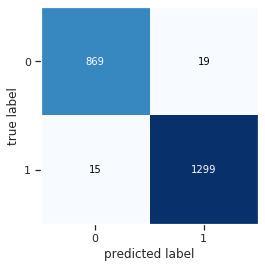

In [8]:
drop_const = VarianceThreshold()
scaler = MinMaxScaler()
imputer = SimpleImputer()

lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42)

# pipe = make_pipeline(make_union(cat_pipe, ColumnSelector(cont_cols)), binner, drop_const, scaler, lr)
pipe = make_pipeline(make_union(cat_pipe, ColumnSelector(cont_cols)), imputer, drop_const, scaler, lr)
pipe.fit(X_train, y_train)

# make predictions on training set
y_guess = pipe.predict(X_train)

# make predictions on hold-out set
y_score = pipe.predict(X_test)

#ranked_predictions = predictions.rank(pct=True, method="first")
print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))

cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

In [10]:
X_TRY = df_test[used_cols]

In [25]:
x = (pipe.predict_proba(X_TRY)[:,1] > .2).astype(np.int).tolist()
# pipe.predict(X_TRY)

In [26]:
print('bot: '+ str(x.count(1)))
print('real: '+ str(x.count(0)))

bot: 22
real: 17006


In [13]:
df_test['bot'] = x

In [14]:
df_to_Csv = df_test[df_test.bot  == 0].user_id.reset_index()

In [17]:
df_to_Csv.head()

,index,user_id
0,0,765
1,1,3839
2,2,7578
3,3,10707
4,4,12916


In [18]:
df_to_Csv.to_csv('NOTBOTS.csv', index = False)

TRAIN accuracy: 1.0
TEST accuracy: 0.991371480472298


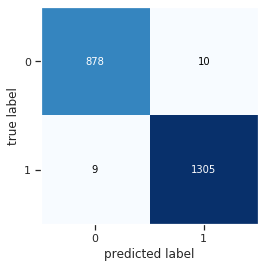

In [10]:
lgm = LGBMClassifier()
#fit
pipe2 = make_pipeline(make_union(cat_pipe, ColumnSelector(cont_cols)), imputer, drop_const, scaler, lgm)
pipe2.fit(X_train, y_train)

# make predictions on training set
y_guess = pipe2.predict(X_train)

# make predictions on hold-out set
y_score = pipe2.predict(X_test)

#print accuacy
print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))

#confusion matrix
cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

In [11]:
X_TRY = df_test[used_cols]

In [14]:
x = (pipe2.predict_proba(X_TRY)[:,1] > .15).astype(np.int).tolist()

In [15]:
print('bot: '+ str(x.count(1)))
print('real: '+ str(x.count(0)))

bot: 13
real: 17015


TRAIN accuracy: 1.0
TEST accuracy: 0.991371480472298


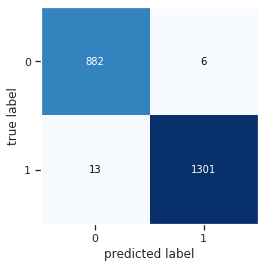

In [22]:
rf = RandomForestClassifier()

pipe3 = make_pipeline(objectify, encoder, binner, scaler, rf)
pipe3.fit(X_train, y_train)

# make predictions on training set
y_guess = pipe3.predict(X_train)

# make predictions on hold-out set
y_score = pipe3.predict(X_test)

print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))

cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

Feature ranking:
1. feature 13 (0.231197)
2. feature 10 (0.147114)
3. feature 8 (0.122129)
4. feature 9 (0.099032)
5. feature 11 (0.074632)
6. feature 7 (0.069568)
7. feature 0 (0.067517)
8. feature 12 (0.058880)
9. feature 14 (0.034699)
10. feature 4 (0.029686)
11. feature 2 (0.022479)
12. feature 5 (0.019304)
13. feature 3 (0.013915)
14. feature 1 (0.005860)
15. feature 6 (0.003986)
16. feature 17 (0.000000)
17. feature 23 (0.000000)
18. feature 22 (0.000000)
19. feature 16 (0.000000)
20. feature 21 (0.000000)
21. feature 20 (0.000000)
22. feature 19 (0.000000)
23. feature 24 (0.000000)
24. feature 18 (0.000000)
25. feature 15 (0.000000)
26. feature 25 (0.000000)


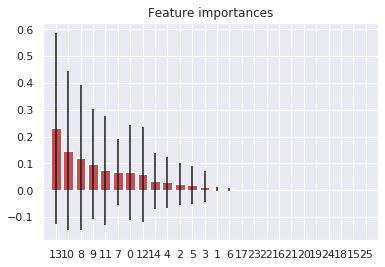

In [23]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()